<a href="https://colab.research.google.com/github/allexanderprastya/PROJECT-TA-JURNAL/blob/main/BERTBaseMultilingual_16_TextBlob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Sentiment Analysis with BERT

In [1]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.25.1



In [5]:
# Setup & Config
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid',font_scale= 1.2)
sns.set_palette(sns.color_palette("bright"))

import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
    )

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap
from accelerate import Accelerator
accelerator = Accelerator()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Exploration

## Download the dataset

In [6]:
df = pd.read_csv("/content/labelTextBlob_no_stemming.csv")

In [7]:
df.columns

Index(['content', 'polarity', 'label'], dtype='object')

In [8]:
df = df[["content", "label"]]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14341 entries, 0 to 14340
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  14341 non-null  object
 1   label    14341 non-null  object
dtypes: object(2)
memory usage: 224.2+ KB


In [10]:
# helper function to draw percentage above each bar
def draw_percentage(ax,total=float(len(df))):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom')

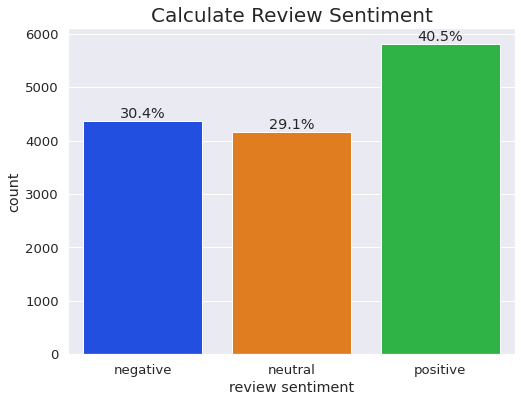

In [11]:
plt.figure(figsize = (8,6))
total = float(len(df))
ax = sns.countplot(x = 'label',data=df)

class_names = ['negative', 'neutral', 'positive']
ax.set_xticklabels(class_names)
plt.title('Calculate Review Sentiment', fontsize=20)
plt.xlabel('review sentiment')
draw_percentage(ax)

plt.show()

In [12]:
# to transform string labels to integer values
LE = LabelEncoder()
df["label"] = LE.fit_transform(df["label"].values)
df


,content,label
0,bangkai turun knock langsung tolong tencent sa...,0
1,mangapa pubg loading login kuota beli,1
2,bug developer perbaiki mengeluh bug lag,1
3,berat putar enak mainnya bagus,2
4,game bagus sayang sinyal turun gameplay sulit ...,0
...,...,...
14336,game grafis buruk high definition keburikannya...,0
14337,lambat,0
14338,bagus banget,2
14339,game seru keren high definition bug pemakaian ...,2


# Data Preprocessing
You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!

In [13]:
PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"

You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [15]:
sample_txt = "Setelah pembaruan terakhir gim ini menjadi sangat buruk Meskipun saya memiliki internet yang layak ini menunjukkan masalah jaringan Selain itu dalam mode solo tidak dapat menemukan saya menunggu selama 3 menit tetapi tidak bisa Saya berharap para pengembang akan melakukan sesuatu tentang masalah ini"

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

 Sentence: Setelah pembaruan terakhir gim ini menjadi sangat buruk Meskipun saya memiliki internet yang layak ini menunjukkan masalah jaringan Selain itu dalam mode solo tidak dapat menemukan saya menunggu selama 3 menit tetapi tidak bisa Saya berharap para pengembang akan melakukan sesuatu tentang masalah ini
   Tokens: ['setelah', 'pe', '##mba', '##ruan', 'terakhir', 'gi', '##m', 'ini', 'menjadi', 'sangat', 'buru', '##k', 'meskipun', 'saya', 'memiliki', 'internet', 'yang', 'lay', '##ak', 'ini', 'menunjukkan', 'masalah', 'jaringan', 'selain', 'itu', 'dalam', 'mode', 'solo', 'tidak', 'dapat', 'menemukan', 'saya', 'menu', '##nggu', 'selama', '3', 'menit', 'tetapi', 'tidak', 'bisa', 'saya', 'ber', '##hara', '##p', 'para', 'peng', '##em', '##bang', 'akan', 'melakukan', 'sesuatu', 'tentang', 'masalah', 'ini']
Token IDs: [15206, 11178, 22028, 77096, 34231, 21464, 10150, 10643, 12227, 20514, 90433, 10167, 34596, 44334, 13656, 12044, 10290, 18844, 10787, 10643, 37271, 39377, 35178, 23274, 120

## Special Tokens
[SEP] - marker for ending of a sentence

In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [20]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the encode_plus() method:

In [21]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=64,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [22]:
print(len(encoding["input_ids"][0]))
encoding["input_ids"][0]

64


tensor([  101, 15206, 11178, 22028, 77096, 34231, 21464, 10150, 10643, 12227,
        20514, 90433, 10167, 34596, 44334, 13656, 12044, 10290, 18844, 10787,
        10643, 37271, 39377, 35178, 23274, 12068, 10693, 16354, 11174, 12017,
        13673, 54609, 44334, 43182, 44058, 19485,   124, 70171, 17056, 12017,
        17349, 44334, 64560, 28467, 10373, 10239, 79112, 10537, 22110, 13727,
        27303, 38264, 23187, 39377, 10643,   102,     0,     0,     0,     0,
            0,     0,     0,     0])

The attention mask has the same length:

In [23]:
print(len(encoding["attention_mask"][0]))
encoding["attention_mask"]

64


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [24]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

['[CLS]',
 'setelah',
 'pe',
 '##mba',
 '##ruan',
 'terakhir',
 'gi',
 '##m',
 'ini',
 'menjadi',
 'sangat',
 'buru',
 '##k',
 'meskipun',
 'saya',
 'memiliki',
 'internet',
 'yang',
 'lay',
 '##ak',
 'ini',
 'menunjukkan',
 'masalah',
 'jaringan',
 'selain',
 'itu',
 'dalam',
 'mode',
 'solo',
 'tidak',
 'dapat',
 'menemukan',
 'saya',
 'menu',
 '##nggu',
 'selama',
 '3',
 'menit',
 'tetapi',
 'tidak',
 'bisa',
 'saya',
 'ber',
 '##hara',
 '##p',
 'para',
 'peng',
 '##em',
 '##bang',
 'akan',
 'melakukan',
 'sesuatu',
 'tentang',
 'masalah',
 'ini',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length
BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [25]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, truncation=True)
    token_lens.append(len(tokens))

and plot the distribution:

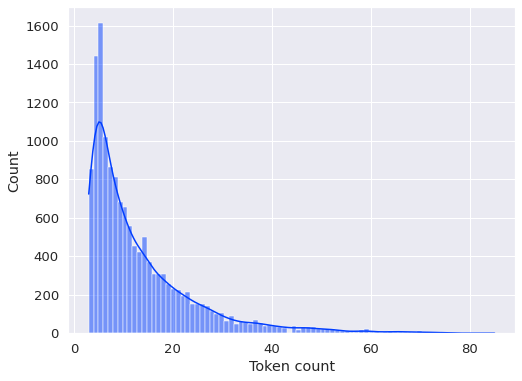

In [26]:
plt.figure(figsize = (8,6))
sns.histplot(data = token_lens, kde=True)
plt.xlabel('Token count')
plt.show()

Most of the reviews seem to contain less than 25 tokens, but we'll be on the safe side and choose a maximum length of 35.

In [27]:
MAX_LEN = 80

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [28]:
class AppReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    # langkah 1: dapatkan review dan target
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
    # langkah 2: menggunakan tokenizer untuk mengkodekan kalimat (termasuk padding/cutting ke panjang maksimal)
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True, # menambahkan '[CLS]' dan '[SEP]'
            max_length = self.max_len, 
            return_token_type_ids = False,
            padding = "max_length", # Padding kalimat menjadi panjang maksimum.
            truncation = True, # Potong kalimat menjadi panjang maksimum.
            return_attention_mask = True, # Kembali attention mask
            return_tensors = "pt", # Kembali  torch objects/tensor
        )

        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(), # Tensor ID token untuk dimasukkan ke dalam model
            "attention_mask": encoding["attention_mask"].flatten(), #Tensor Index yang menentukan token mana yang harus diperhatikan oleh model
            "targets": torch.tensor(target, dtype=torch.long),
        }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [29]:
#pisahkan data train, validation dan test (rasio 80:10:10)
df_train, df_test = train_test_split(
    df,
    test_size = 0.2,
    random_state = RANDOM_SEED,
    stratify=df['label']
    )

df_val, df_test = train_test_split(
    df_test,
    test_size = 0.5,
    random_state = RANDOM_SEED,
    stratify=df_test['label']
    )

In [30]:
print('Train Data Size', df_train.shape)
print('Validation Data Size', df_val.shape)
print('Test Data Size', df_test.shape)

Train Data Size (11472, 2)
Validation Data Size (1434, 2)
Test Data Size (1435, 2)


In [31]:
df_train['label'].value_counts()

2    4651
0    3488
1    3333
Name: label, dtype: int64

In [32]:
df_val['label'].value_counts()

2    581
0    436
1    417
Name: label, dtype: int64

In [33]:
df_test['label'].value_counts()

2    582
0    436
1    417
Name: label, dtype: int64

We also need to create a couple of data loaders. Here's a helper function to do it:

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = AppReviewDataset(
        reviews = df.content.to_numpy(),
        targets = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
        )

    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 2
        )

In [35]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(
    df_train,
    tokenizer,
    MAX_LEN,
    BATCH_SIZE
    )

val_data_loader = create_data_loader(
    df_val,
    tokenizer,
    MAX_LEN,
    BATCH_SIZE
    )

test_data_loader = create_data_loader(
    df_test,
    tokenizer,
    MAX_LEN,
    BATCH_SIZE
    )

Let's have a look at an example batch from our training data loader:

In [36]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)

torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face
There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else.

But who cares, right? We're hardcore! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [39]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
    )

The last_hidden_state is a sequence of hidden states of the last layer of the model.

In [40]:
last_hidden_state.shape

torch.Size([1, 64, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [41]:
bert_model.config.hidden_size

768

We can use all of this knowledge to create a classifier that uses the BERT model:

In [42]:
class TextClassificationModel(nn.Module):
    def __init__(self, n_classes):
        super(TextClassificationModel, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(
            self.bert.config.hidden_size,
            n_classes
            )

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
            )
        
        output = self.drop(pooled_output)
        return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [43]:
model = TextClassificationModel(len(class_names))
model = model.to(device)

In [44]:
model

TextClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

We'll move the example batch of our training data to the GPU:

In [45]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape)  # batch size x seq length

torch.Size([16, 80])
torch.Size([16, 80])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [46]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3703, 0.3164, 0.3133],
        [0.3281, 0.3192, 0.3526],
        [0.3138, 0.3351, 0.3511],
        [0.3016, 0.3277, 0.3708],
        [0.3160, 0.3550, 0.3290],
        [0.2889, 0.3687, 0.3424],
        [0.3013, 0.3414, 0.3574],
        [0.3404, 0.3351, 0.3246],
        [0.3353, 0.3424, 0.3223],
        [0.3060, 0.3473, 0.3467],
        [0.3196, 0.3254, 0.3550],
        [0.2697, 0.3362, 0.3942],
        [0.3042, 0.3072, 0.3886],
        [0.3297, 0.3420, 0.3283],
        [0.3484, 0.3187, 0.3329],
        [0.3202, 0.3810, 0.2988]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [47]:
EPOCHS = 5
LR = 2e-5

optimizer = optim.AdamW(
    model.parameters(),
    lr = LR
    )

total_steps = EPOCHS * len(train_data_loader) 

scheduler = get_linear_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
    )
# For multi-class classification you would usually just use nn.CrossEntropyLoss 
loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 2e-5
-Number of epochs: 5

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [48]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):

    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask =attention_mask
            )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        accelerator.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_gradnorm](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [49]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
                )
            
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [50]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 65)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(df_train)
      )

  print(f'Train loss: {train_loss}\t Accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(df_val)
      )
  
  print(f'Valid loss: {val_loss}\t Accuracy: {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)                             
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
    
  if val_acc > best_accuracy:
    torch.save(
        model.state_dict(),
        'best_pretrained_model_bert.bin'
        )
    best_accuracy = val_acc

Epoch 1/5
-----------------------------------------------------------------
Train loss: 0.5608150692893039	 Accuracy: 0.7688284518828452
Valid loss: 0.3697067633685138	 Accuracy: 0.8675034867503486

Epoch 2/5
-----------------------------------------------------------------
Train loss: 0.29668228664906954	 Accuracy: 0.8959205020920502
Valid loss: 0.31742207049909565	 Accuracy: 0.900278940027894

Epoch 3/5
-----------------------------------------------------------------
Train loss: 0.19758779909643584	 Accuracy: 0.9388075313807531
Valid loss: 0.3561580660972848	 Accuracy: 0.9156206415620641

Epoch 4/5
-----------------------------------------------------------------
Train loss: 0.14204720670056648	 Accuracy: 0.9609483960948396
Valid loss: 0.36657346395077184	 Accuracy: 0.9267782426778243

Epoch 5/5
-----------------------------------------------------------------
Train loss: 0.10105936918092692	 Accuracy: 0.9733263598326359
Valid loss: 0.38371479290847976	 Accuracy: 0.9295676429567643


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

In [51]:
train_acc = [i.cpu() for i in history['train_acc']]
val_acc = [i.cpu() for i in history['val_acc']]

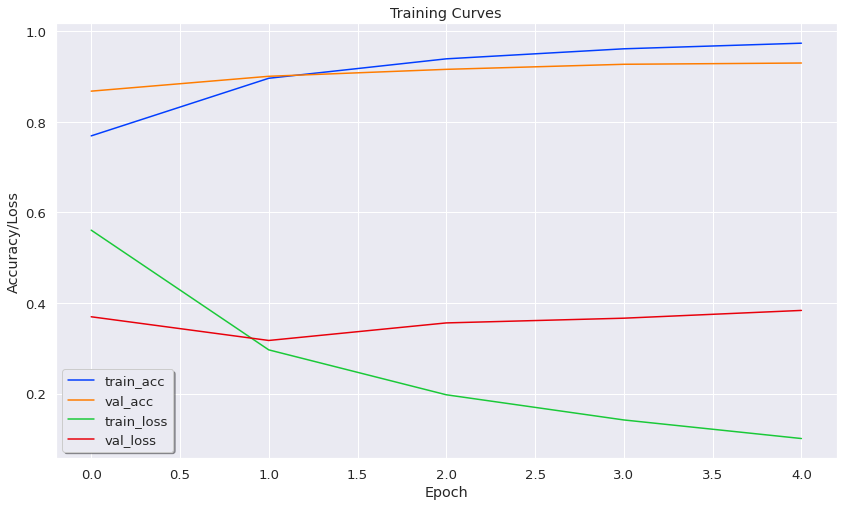

In [52]:
plt.figure(figsize = (14,8))
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')

plt.title('Training Curves')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left', shadow=True)
plt.show()

The training accuracy starts to approach 100% after 6 epochs or so.

## Download the pre-trained model by uncommenting the below section if you don't want to do training

In [53]:
model.load_state_dict(
    torch.load(
        "/content/best_pretrained_model_bert.bin",
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

# Evaluation
So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [54]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.9240418118466899

Our model seems to generalize well as test accuracy is almost equal to validation accuracy.

We'll define a helper function to get the predictions from our model:

In [55]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [56]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let's have a look at the classification report

In [57]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.91      0.91       436
     neutral       0.94      0.91      0.92       417
    positive       0.92      0.95      0.93       582

    accuracy                           0.92      1435
   macro avg       0.93      0.92      0.92      1435
weighted avg       0.92      0.92      0.92      1435



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

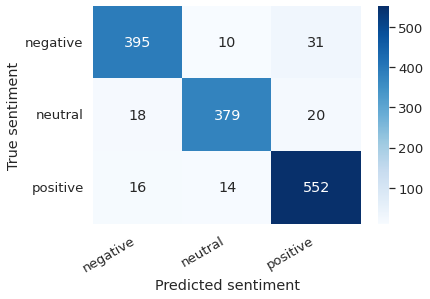

In [58]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel("True sentiment")
    plt.xlabel("Predicted sentiment")


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [59]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({"class_names": class_names, "values": y_pred_probs[idx]})

In [60]:
print("\n".join(wrap(review_text)))
print()
print(f"True sentiment: {class_names[true_sentiment]}")

download habis buka suruh download giga byte sialan

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

Text(0.5, 0, 'probability')

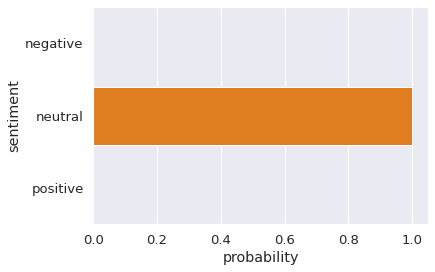

In [61]:
sns.barplot(x="values", y="class_names", data=pred_df, orient="h")
plt.ylabel("sentiment")
plt.xlabel("probability")

# Predicting on Raw Text
Let's use our model to predict the sentiment of some raw text:

In [62]:
review_text = "Setelah pembaruan terakhir gim ini menjadi sangat buruk Meskipun saya memiliki internet yang layak ini menunjukkan masalah jaringan Selain itu dalam mode solo tidak dapat menemukan saya menunggu selama 3 menit tetapi tidak bisa Saya berharap para pengembang akan melakukan sesuatu tentang masalah ini"

We have to use the tokenizer to encode the text:

In [63]:
encoded_review = tokenizer.encode_plus(
    review_text,
    add_special_tokens = True, # menambahkan '[CLS]' dan '[SEP]'
    max_length = MAX_LEN, 
    return_token_type_ids = False,
    padding = "max_length", # Padding kalimat menjadi panjang maksimum.
    truncation = True, # Potong kalimat menjadi panjang maksimum.
    return_attention_mask = True, # Kembali attention mask
    return_tensors = "pt", # Kembali  torch objects/tensor
    )



Let's get the predictions from our model:

In [64]:
input_ids = encoded_review["input_ids"].to(device)
attention_mask = encoded_review["attention_mask"].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f"Review text: {review_text}")
print(f"Sentiment  : {class_names[prediction]}")

Review text: Setelah pembaruan terakhir gim ini menjadi sangat buruk Meskipun saya memiliki internet yang layak ini menunjukkan masalah jaringan Selain itu dalam mode solo tidak dapat menemukan saya menunggu selama 3 menit tetapi tidak bisa Saya berharap para pengembang akan melakukan sesuatu tentang masalah ini
Sentiment  : positive


# Summary
Nice job! You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

# References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)